In [1]:
import Pkg
Pkg.activate("BosonStars")
# Pkg.resolve()

using Skylight
using CairoMakie
using Printf

include("bosonstar_parameters.jl")


  Activating project at `~/BosonStars/BosonStars`


79.8

In [10]:
Nstr = "1200"
modeltype = "SBS"
modelid = 3
modelname = modeltype*string(modelid)
ξstr = "85"        
filename =  "$(modelname)_i$(ξstr)deg_N$(Nstr)"

initial_data = load_initial_data_from_hdf5("io/$(filename).h5")
output_data = load_output_data_from_hdf5("io/$(filename).h5", 1)

8×1440000 Matrix{Float64}:
 -1077.06         -1077.07         …  -1077.07         -1077.06
   566.698          566.698             566.698          566.698
     1.68779          1.68771             1.62834          1.62825
    -3.11162         -3.11175             3.1119           3.11177
    -0.999557        -0.999557           -0.999557        -0.999557
     0.990052         0.990062     …      0.990062         0.990052
    -0.00013571      -0.000135713         0.000136419      0.00013642
    -0.000137483     -0.000137251         0.000135832      0.000136058

In [16]:
a = eval(Symbol("a_$(modelname)"))
b = eval(Symbol("b_$(modelname)"))
rin = eval(Symbol("rin_$(modelname)"))
rout = eval(Symbol("rout_$(modelname)"))
tempfilename = "tables/Temp$(modelname).dat"

spacetime = BosonStarSpacetime(a=a,b=b)

ξ = parse(Int, ξstr)
Nres = parse(Int, Nstr)
    
camera = ImagePlane(distance = 500.0,
                        observer_inclination_in_degrees = ξ,
                        horizontal_side = rout*1.1,
                        vertical_side = rout*1.1,
                        horizontal_number_of_pixels = Nres,
                        vertical_number_of_pixels = Nres)

model = AccretionDiskWithTabulatedTemperature(inner_radius=rin, outer_radius=rout, filename=tempfilename)
        
configurations = VacuumOTEConfigurations(spacetime=spacetime,
                                        camera = camera,
                                        radiative_model = model,
                                        unit_mass_in_solar_masses=1.0)

VacuumOTEConfigurations{BosonStarSpacetime, AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}, ImagePlane}
  spacetime: BosonStarSpacetime
  radiative_model: AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}
  camera: ImagePlane
  unit_mass_in_solar_masses: Float64 1.0


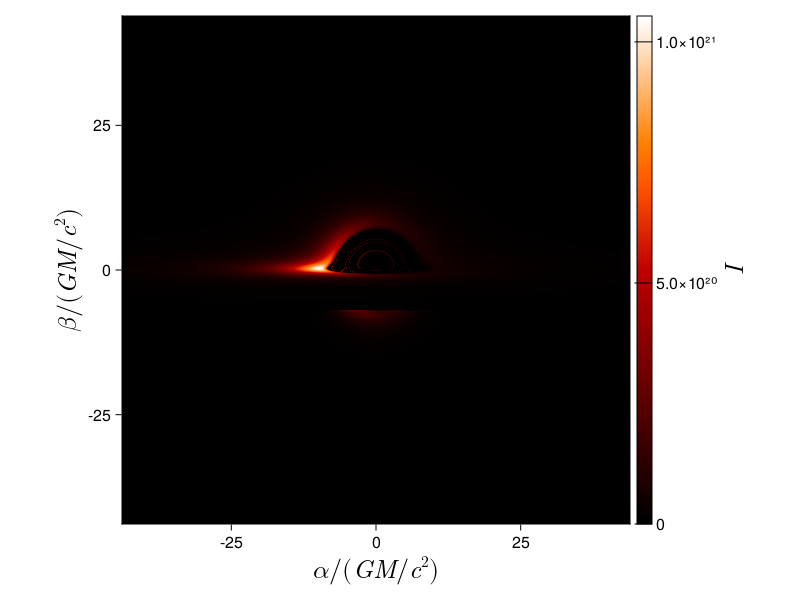

CairoMakie.Screen{IMAGE}


In [20]:
bolometric_intensities, q = observed_bolometric_intensities(initial_data, output_data, configurations)
xs,ys = axes_ranges(camera)
zs = grid_view(bolometric_intensities, configurations)

# joint_limits = (1e4,2e5)
fig = Figure()
ax = Axis(fig[1,1], xlabel=L"\alpha/(GM/c^2)", ylabel=L"\beta/(GM/c^2)", ylabelsize = 26, xlabelsize = 26) 
hmap = heatmap!(xs, ys, zs; colormap=:gist_heat, interpolate=true)#, colorrange=joint_limits)
Colorbar(fig[:, end+1], hmap, label=L"I", labelsize=26, width = 15, ticksize = 18, tickalign = 1)
colsize!(fig.layout, 1, Aspect(1, 1.0))
colgap!(fig.layout, 7)
display(fig)

In [ ]:

filenames = Matrix{String}(undef, 3, 3)
model = "SBS"
inclinations = [5, 45, 85]

for i in 1:3
    for j in 1:3
        ξ = inclinations[j]
        ξ = 5*(i-1)
        ξstr = string(@sprintf("%02d", ξ))
        Nres = 400*(j+1)
        Nstr = string(@sprintf("%03d", Nres))
        filenames[i,j] = "$(modelname)_i$(ξstr)deg_N$(Nstr)"
    end
end

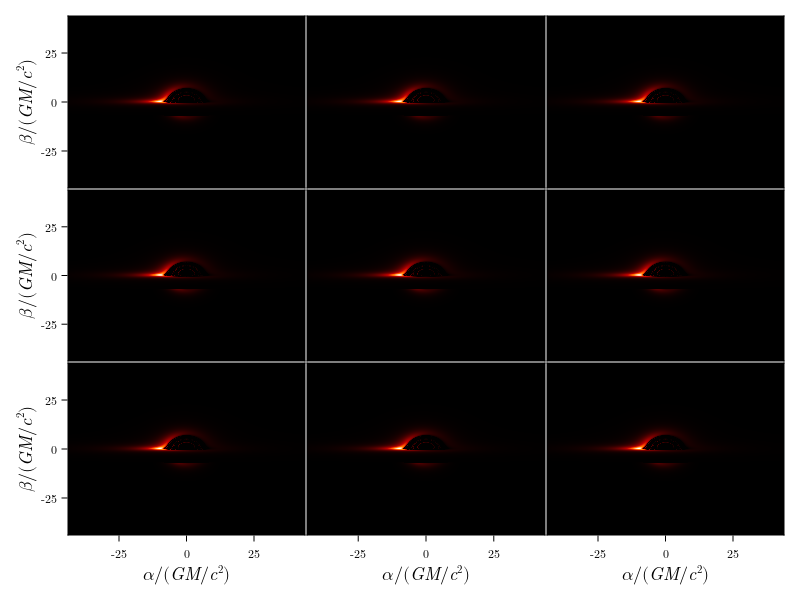

CairoMakie.Screen{IMAGE}


In [74]:
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(3, 3)
fig = Figure(layout = layout)

axes = Matrix{Axis}(undef, 3, 3)

for i in 1:3, j in 1:3
    ax = Axis(fig[i,j])
    axes[i,j] = ax
    hmap = heatmap!(xs, ys, zs; colormap=:gist_heat, interpolate=true)#, colorrange=joint_limits)
    ax.xticklabelsize = 12
    ax.yticklabelsize = 12

    if j == 1
        colorrange = ranges(filenames[i,:])
        cbar = Colorbar(fig[i,4], hmap, label=L"I", labelsize=26, width = 15, ticksize = 18, tickalign = 1, colorrange = colorrange)
    end
    # colsize!(fig.layout[i,j], 1, Aspect(1, 1.0))
    # colgap!(fig.layout[i,j], 7)
    # colorbar!(ax, label=L"I", labelsize=26, width = 15, ticksize = 18, tickalign = 1)
end
for k in 1:3
    axbottom = axes[3,k]
    axright = axes[k,1]

    axbottom.xlabel = L"\alpha/(GM/c^2)"
    axbottom.xlabelsize = 18
    axbottom.xticklabelsize = 12

    axright.ylabel = L"\beta/(GM/c^2)"
    axright.ylabelsize = 18
    axright.yticklabelsize = 12

    for l in 1:2
        hidexdecorations!(axes[l,k])
        hideydecorations!(axes[k,l+1])
    end
end
# for i in 1:3
#     c = Colorbar(fig[i,4], hmap, label=L"I")
# end
colgap!(fig.layout, 2)
rowgap!(fig.layout, 2)
display(fig)